In [1]:
import ot
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import paired_distances

import numpy as np
from matplotlib import pyplot as plt
from imageio import imread
import tensorflow as tf
from skimage.morphology import dilation,erosion,opening,closing,square,diamond

2023-06-02 19:48:58.473483: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-02 19:48:58.473505: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Get the CIFAR dataset

In [2]:
(xtr, ytr), (xte, yte) = tf.keras.datasets.cifar10.load_data()

# Get the first 50 images!
xtr = xtr[0:50]/255
xte = xte[0:50]/255

# Morphological Operators for Color Images

In [3]:
SE_size = 3
SE = square(SE_size)

def h_mean(I):
    return np.mean(I, axis=2)

def h_median(I):
    return np.median(I, axis=2)

def h_rgb(I):
    return 255*(255*I[:,:,0]+I[:,:,1])+I[:,:,2]

# h-moprhological operator

def hMM(I, h = h_mean, mm_op = dilation, SE = square(7)):
    nr,nc,nb = I.shape
    Data=np.reshape(I,[nr*nc,nb])
    horder = h(I).flatten()
    order = np.argsort(horder[:])
    latt = np.zeros(Data.shape[0],dtype=np.int32)
    latt[order] = np.arange(Data.shape[0])
    latt = np.reshape(latt,[nr,nc])
    mm_latt = mm_op(latt,SE)
    imOut=Data[order[mm_latt],:]
    return np.reshape(imOut,[nr,nc,nb])

# Marginal approach

def marg_op(I, mm_op = erosion, SE = square(7)):
    J = np.zeros_like(I)
    for i in range(3):
        J[:,:,i] = mm_op(I[:,:,i],SE)
    return J

# Global Irregularity Index

In [4]:
def global_irregularity(imI,imJ,metric='euclidean'):
    M,N,K = imI.shape
    a = imI.reshape(M*N,K)
    b = imJ.reshape(M*N,K)
    vu,hu = np.unique(a,return_counts=True,axis=0)
    vv,hv = np.unique(b,return_counts=True,axis=0)
    C = pairwise_distances(vu,vv,metric=metric)
    return 1-ot.emd2(1.0*hu,1.0*hv,C)/np.sum(paired_distances(a,b,metric=metric))

# Apply morphological operators on some images

In [5]:
ytr_dil = list() # Desired dilated output images;
ytr_ero = list() # Desired eroded output images;
ytr_open = list() # Desired opening output images;
ytr_clos = list() # Desired closing output images;
for x in xtr:
    ytr_dil.append(hMM(x, mm_op = dilation, SE = SE))   
    ytr_ero.append(hMM(x, mm_op = erosion, SE = SE))
    ytr_open.append(hMM(x, mm_op = opening, SE = SE))
    ytr_clos.append(hMM(x, mm_op = closing, SE = SE))
ytr_dil = np.stack(ytr_dil,axis=0)
ytr_ero = np.stack(ytr_ero,axis=0)
ytr_open = np.stack(ytr_open,axis=0)
ytr_clos = np.stack(ytr_clos,axis=0)

xtr.shape, ytr_dil.shape, ytr_ero.shape, ytr_open.shape, ytr_clos.shape

((50, 32, 32, 3),
 (50, 32, 32, 3),
 (50, 32, 32, 3),
 (50, 32, 32, 3),
 (50, 32, 32, 3))

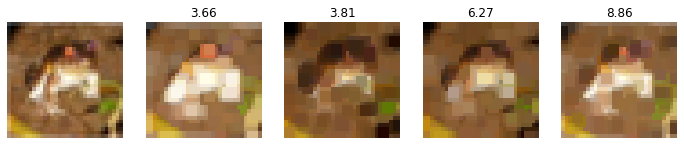

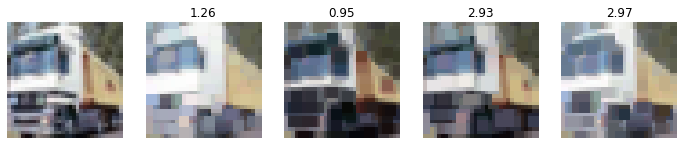

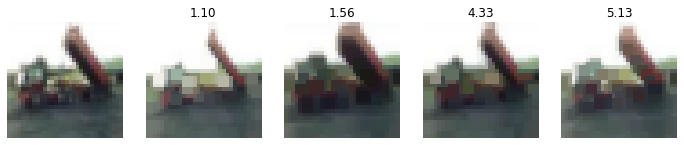

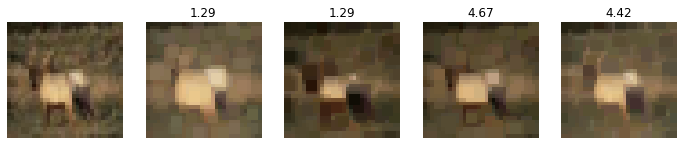

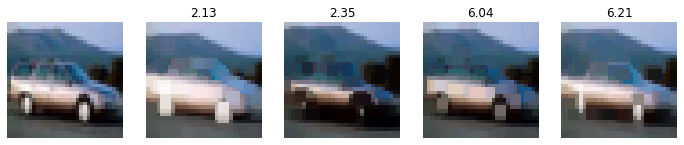

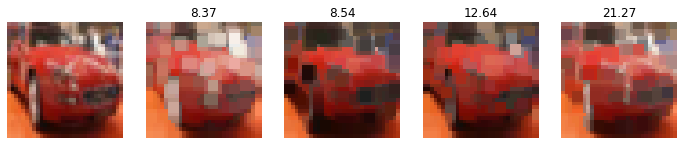

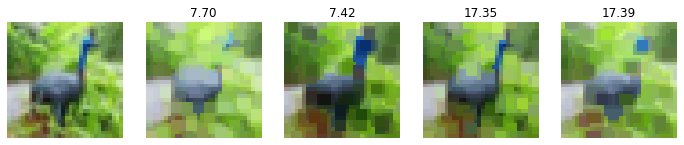

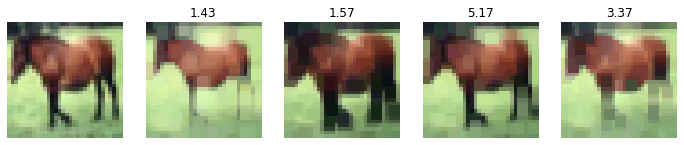

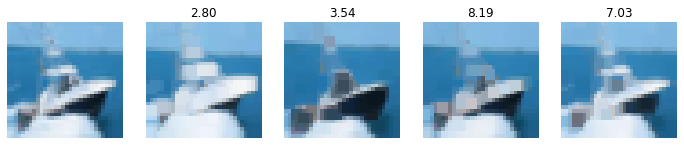

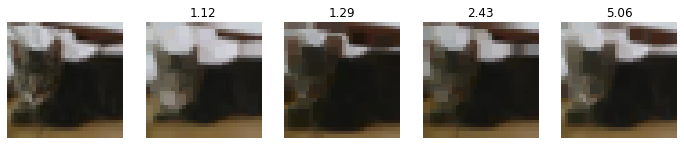

In [7]:
Nimgs = 10
for i in range(Nimgs):
    plt.figure(figsize=(12,12))
    plt.subplot(1,5,1)
    plt.imshow(xtr[i])
    plt.axis('off')

    plt.subplot(1,5,2)
    plt.imshow(ytr_dil[i])
    plt.title('%2.2f' % (100*global_irregularity(xtr[i],ytr_dil[i])))
    plt.axis('off')
    
    plt.subplot(1,5,3)
    plt.imshow(ytr_ero[i])
    plt.title('%2.2f' % (100*global_irregularity(xtr[i],ytr_ero[i])))
    plt.axis('off')

    plt.subplot(1,5,4)
    plt.imshow(ytr_open[i])
    plt.title('%2.2f' % (100*global_irregularity(xtr[i],ytr_open[i])))
    plt.axis('off')
    
    plt.subplot(1,5,5)
    plt.imshow(ytr_clos[i])
    plt.title('%2.2f' % (100*global_irregularity(xtr[i],ytr_clos[i])))
    plt.axis('off')
    plt.show()